In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os

(650000, 3)
(2274, 7)


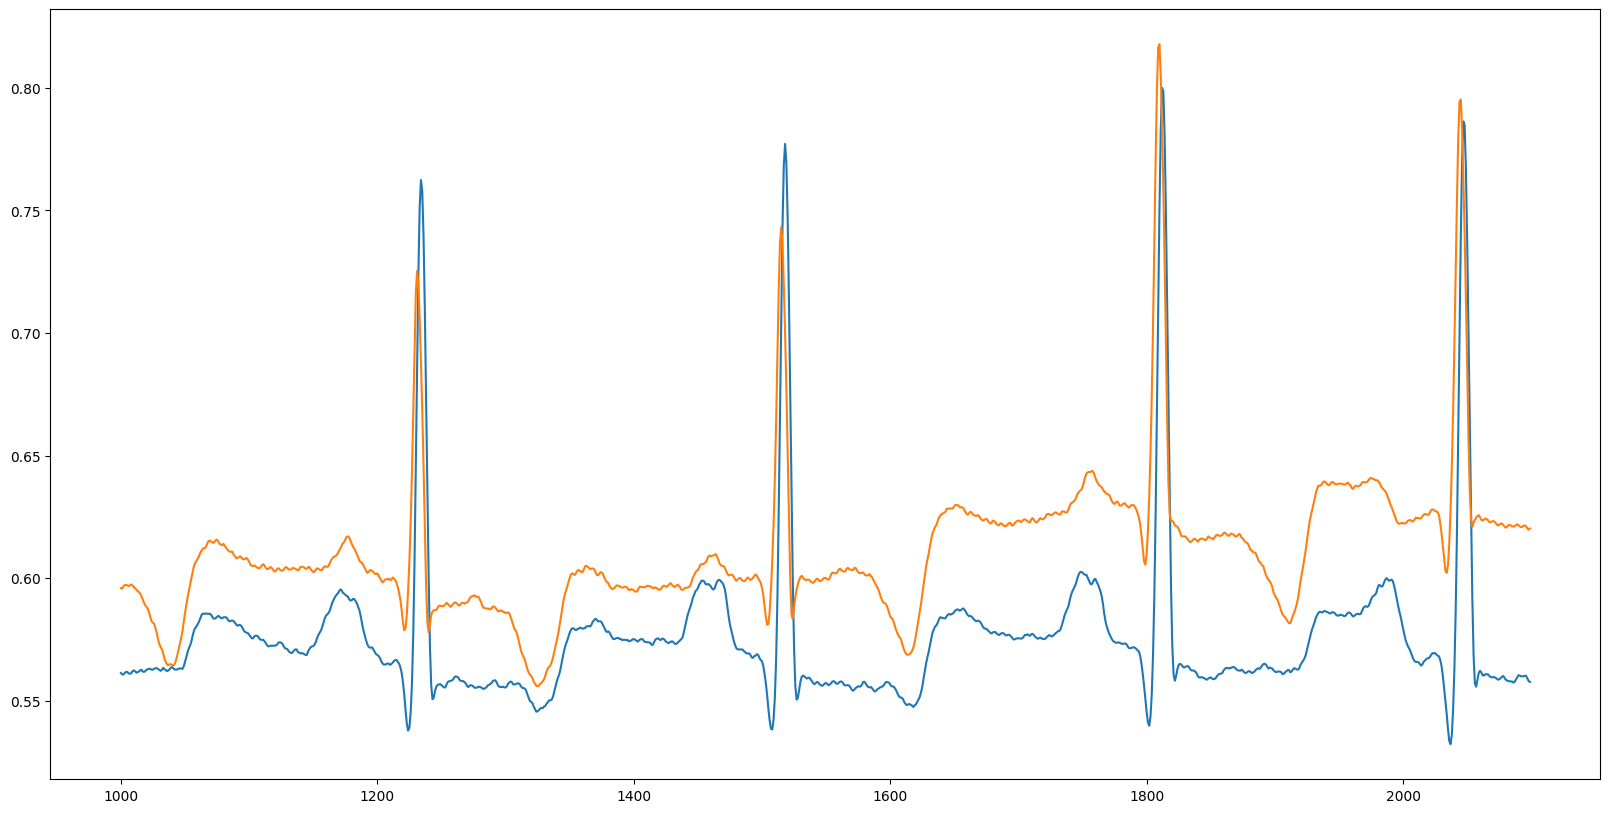

In [25]:
### Patient 100 example

# Reading ecg data
df_ecg = pd.read_csv('data/100.csv', quotechar="'")
df_ecg.rename(columns={'sample #':'Sample #'}, inplace=True)
print(df_ecg.shape)

# Reading annotations
df_annotations = pd.read_csv('data/100annotations.txt', sep='\s+')
df_annotations['Aux'] = df_annotations['Num'] 
df_annotations['Num'] = df_annotations['Chan']
df_annotations['Chan'] = df_annotations['Sub']
df_annotations['Sub'] = df_annotations['Type']
df_annotations['Type'] = df_annotations['#']
df_annotations.rename(columns={'Sample':'Sample #'}, inplace=True)
df_annotations.drop('#', axis=1, inplace=True)
print(df_annotations.shape)

# Merging ecg and annotations
df = pd.merge(df_ecg, df_annotations, on='Sample #', how='outer')

# Scaling MLII and V5
scaler = MinMaxScaler()
MLII = df['MLII'].to_numpy()
V5 = df['V5'].to_numpy()
df['MLII'] = scaler.fit_transform(MLII.reshape(-1, 1))
df['V5'] = scaler.fit_transform(V5.reshape(-1, 1))

# Filtering MLII and V5 with moving average
df['MLII'] = df['MLII'].rolling(window=8).mean()
df['V5'] = df['V5'].rolling(window=8).mean()

# Plotting MLII and V5
plt.figure(figsize=(20, 10))
plt.plot(df['Sample #'][1000:2100], df['MLII'][1000:2100])
plt.plot(df['Sample #'][1000:2100], df['V5'][1000:2100])

In [26]:
# Getting all filenames in data folder
folder_name = 'data'
folder_path = os.path.join(os.getcwd(), folder_name)
filenames = os.listdir(folder_path)
#print(filenames)

# Reading all ecg data
df_ecg = pd.DataFrame()
for filename in filenames:
    if filename.endswith('.csv'):
        df_temp = pd.read_csv(os.path.join(folder_path, filename), quotechar="'")
        df_temp.rename(columns={'sample #':'Sample #'}, inplace=True)
        # Add column to df to identify patient ID
        df_temp['Patient'] = filename.split('.')[0]
        df_ecg = pd.concat([df_ecg, df_temp], axis=0, ignore_index=True)

# Reading all annotations
df_annotations = pd.DataFrame()
for filename in filenames:
    if filename.endswith('.txt'):
        df_temp = pd.read_csv(os.path.join(folder_path, filename), sep='\s+', engine='python')
        df_temp['Aux'] = df_temp['Num'] 
        df_temp['Num'] = df_temp['Chan']
        df_temp['Chan'] = df_temp['Sub']
        df_temp['Sub'] = df_temp['Type']
        df_temp['Type'] = df_temp['#']
        df_temp.rename(columns={'Sample':'Sample #'}, inplace=True)
        df_temp.drop('#', axis=1, inplace=True)
        # Add column to df to identify patient ID
        df_temp['Patient'] = filename.split('.')[0][0:3]
        df_annotations = pd.concat([df_annotations, df_temp], axis=0, ignore_index=True)

# Merging ecg and annotations
df = pd.merge(df_ecg, df_annotations, on=['Sample #', 'Patient'], how='outer')

Sample #    31200000
MLII        29900000
V5           3250000
Patient     31200000
V1          26000000
V2           2600000
V4            650000
Time          112647
Type          112647
Sub           112647
Chan          112647
Num           112647
Aux             1728
dtype: int64


<BarContainer object of 13 artists>

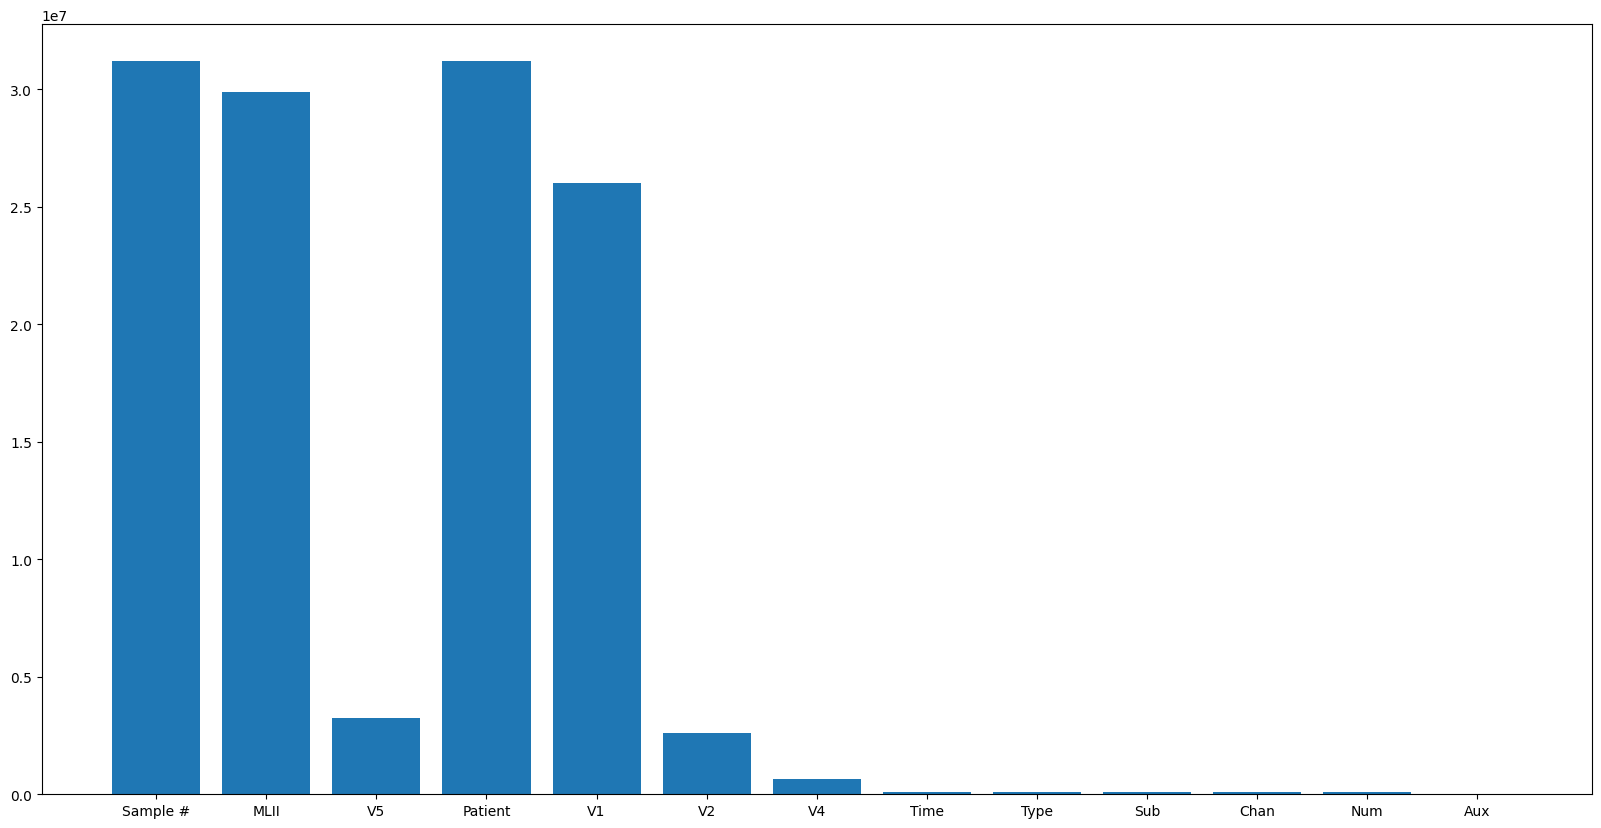

In [27]:
# For each feature count the number of non-null values
print(df.count())

# Plot each feature count in a bar plot
plt.figure(figsize=(20, 10))
plt.bar(df.columns, df.count())

In [28]:
# Print the types of each feature
print(df.dtypes)

Sample #      int64
MLII        float64
V5          float64
Patient      object
V1          float64
V2          float64
V4          float64
Time         object
Type         object
Sub         float64
Chan        float64
Num         float64
Aux          object
dtype: object


In [29]:
# Print the number of samples that are missing MLII
print('Samples missing MLII:', df['MLII'].isnull().sum())

# Print the number of samples that are missing V1, V2, V4 or V5 all at the same time
print('Samples missing V1, V2, V4 or V5 alltogther:', df[['V1', 'V2', 'V4', 'V5']].isnull().all(axis=1).sum())

Samples missing MLII: 1300000
Samples missing V1, V2, V4 or V5 alltogther: 0


In [30]:
df.describe()

,Sample #,MLII,V5,V1,V2,V4,Sub,Chan,Num
count,3.120000e+07,2.990000e+07,3.250000e+06,2.600000e+07,2.600000e+06,650000.000000,112647.000000,112647.0,112647.0
mean,3.249995e+05,9.563606e+02,9.712235e+02,1.004138e+03,1.005862e+03,913.617809,0.062620,0.0,0.0
std,1.876388e+05,9.706090e+01,4.559114e+01,8.301823e+01,1.459426e+02,52.292792,0.406984,0.0,0.0
min,0.000000e+00,0.000000e+00,5.310000e+02,0.000000e+00,0.000000e+00,372.000000,-1.000000,0.0,0.0
25%,1.624998e+05,9.030000e+02,9.470000e+02,9.590000e+02,9.430000e+02,889.000000,0.000000,0.0,0.0
50%,3.249995e+05,9.640000e+02,9.730000e+02,1.023000e+03,1.021000e+03,912.000000,0.000000,0.0,0.0
75%,4.874992e+05,9.970000e+02,9.930000e+02,1.049000e+03,1.050000e+03,936.000000,0.000000,0.0,0.0
max,6.499990e+05,2.047000e+03,1.419000e+03,2.047000e+03,2.047000e+03,1516.000000,9.000000,0.0,0.0


array([[<AxesSubplot: title={'center': 'Sample #'}>,
        <AxesSubplot: title={'center': 'MLII'}>,
        <AxesSubplot: title={'center': 'V5'}>],
       [<AxesSubplot: title={'center': 'V1'}>,
        <AxesSubplot: title={'center': 'V2'}>,
        <AxesSubplot: title={'center': 'V4'}>],
       [<AxesSubplot: title={'center': 'Sub'}>,
        <AxesSubplot: title={'center': 'Chan'}>,
        <AxesSubplot: title={'center': 'Num'}>]], dtype=object)

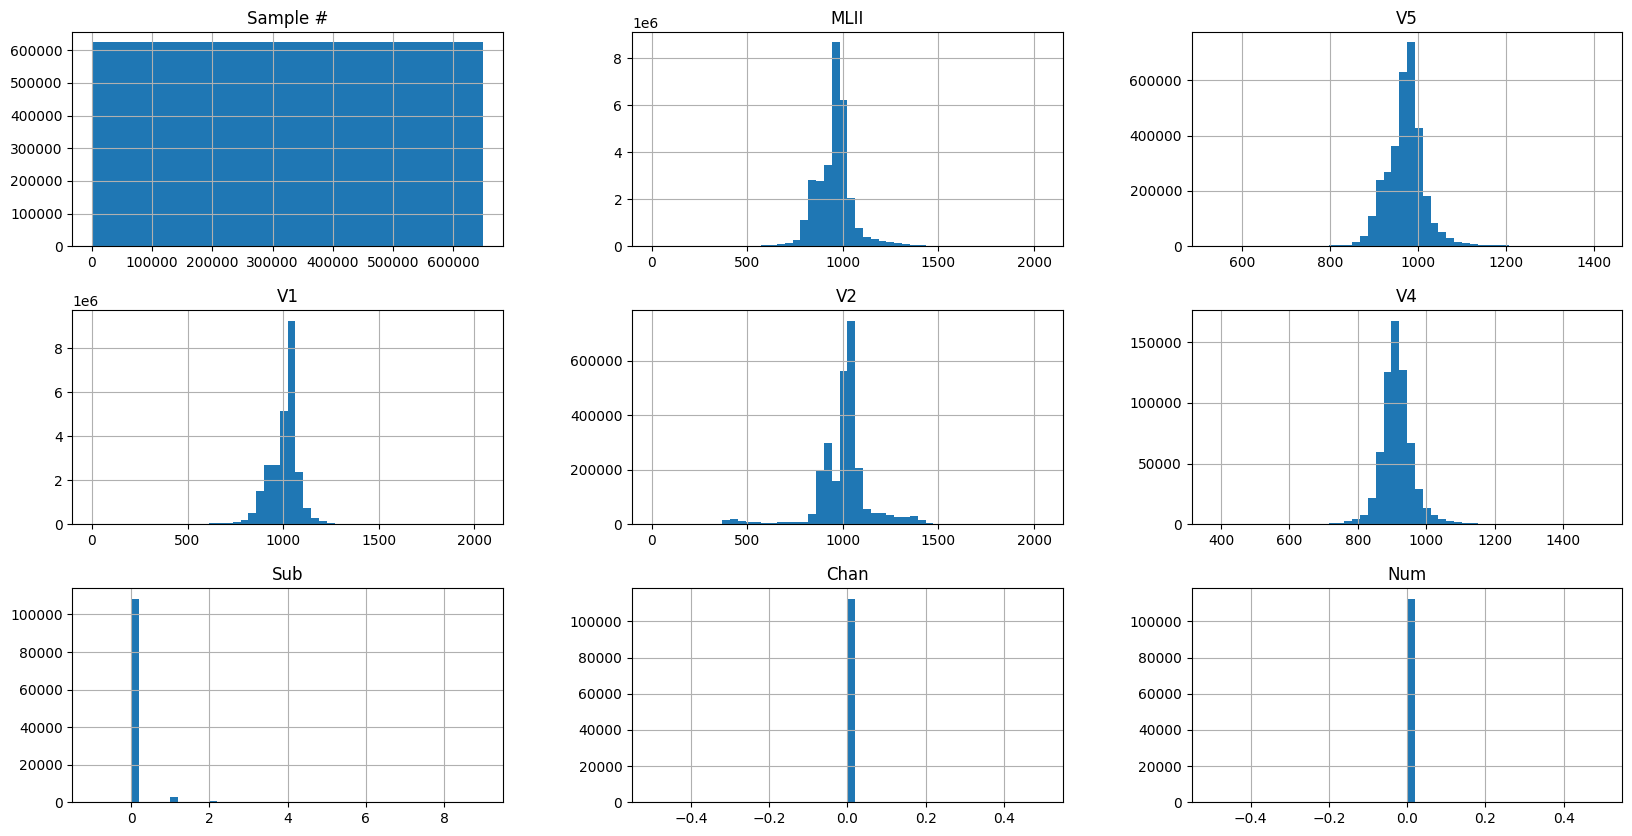

In [31]:
# Plot features histograms with the NaN values removed
df.hist(figsize=(20, 10), bins=50)

{'whiskers': [<matplotlib.lines.Line2D at 0x2310d9ec4f0>,
 'caps': [<matplotlib.lines.Line2D at 0x2310d9eca30>,
 'boxes': [<matplotlib.lines.Line2D at 0x2310d9ec250>],
 'medians': [<matplotlib.lines.Line2D at 0x2310d9ecf70>],
 'fliers': [<matplotlib.lines.Line2D at 0x2310d9ed210>],
 'means': []}

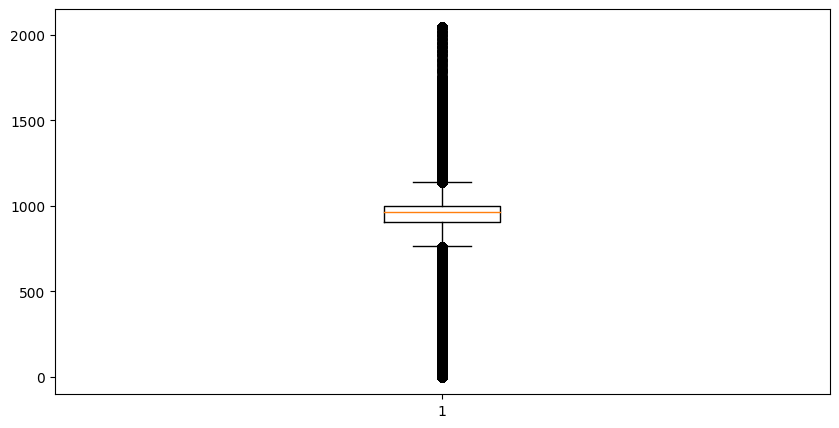

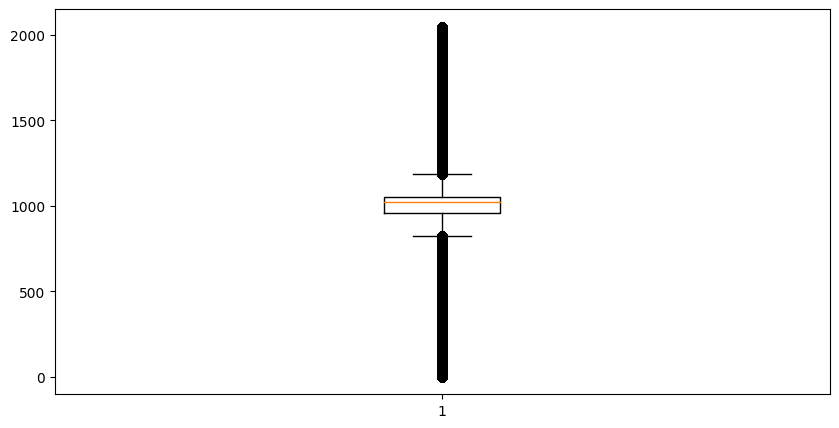

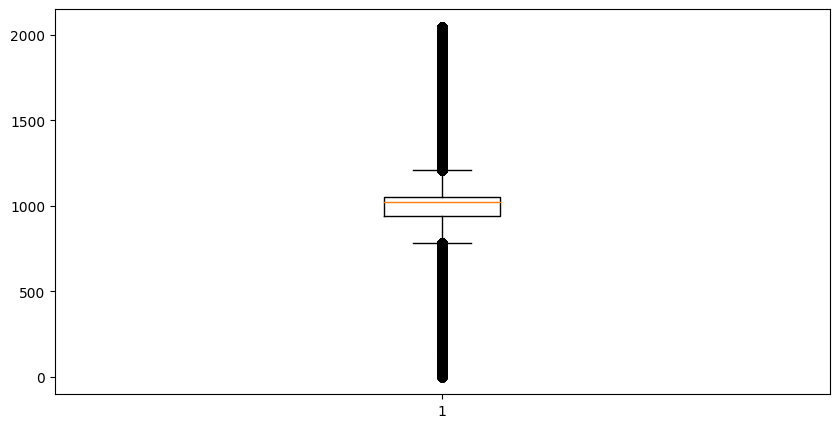

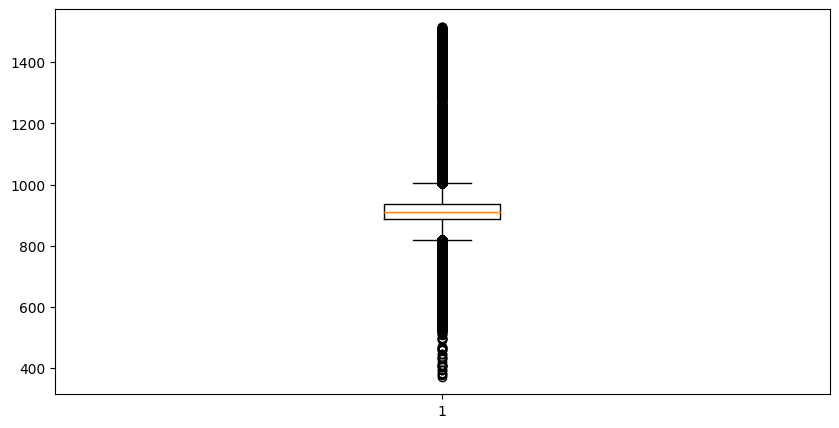

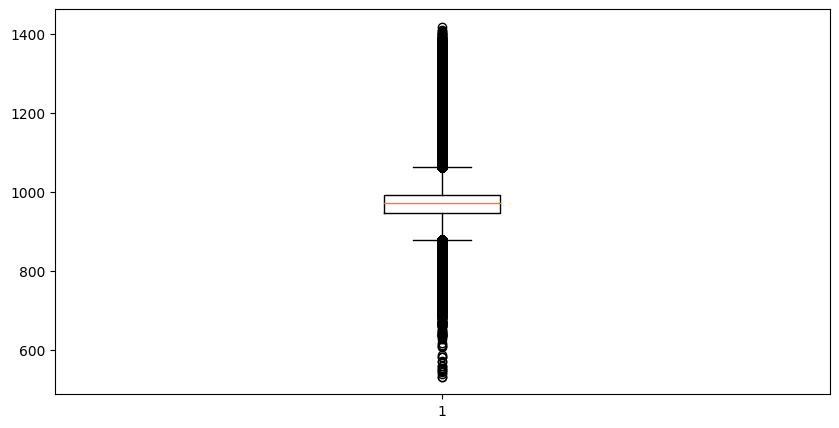

In [32]:
# Remove samples that are missing MLII to a temporary dataframe and make boxplot
df_temp = df[~df['MLII'].isnull()]
plt.figure(figsize=(10, 5))
plt.boxplot(df_temp['MLII'])

# Remove samples that are missing V1 to a temporary dataframe and make boxplot
df_temp = df[~df['V1'].isnull()]
plt.figure(figsize=(10, 5))
plt.boxplot(df_temp['V1'])

# Remove samples that are missing V2 to a temporary dataframe and make boxplot
df_temp = df[~df['V2'].isnull()]
plt.figure(figsize=(10, 5))
plt.boxplot(df_temp['V2'])

# Remove samples that are missing V4 to a temporary dataframe and make boxplot
df_temp = df[~df['V4'].isnull()]
plt.figure(figsize=(10, 5))
plt.boxplot(df_temp['V4'])

# Remove samples that are missing V5 to a temporary dataframe and make boxplot
df_temp = df[~df['V5'].isnull()]
plt.figure(figsize=(10, 5))
plt.boxplot(df_temp['V5'])

In [33]:
# Scaling MLII, V1, V2, V4 and V5
scaler = MinMaxScaler()
MLII = df['MLII'].to_numpy()
V1 = df['V1'].to_numpy()
V2 = df['V2'].to_numpy()
V4 = df['V4'].to_numpy()
V5 = df['V5'].to_numpy()
df['MLII'] = scaler.fit_transform(MLII.reshape(-1, 1))
df['V1'] = scaler.fit_transform(V1.reshape(-1, 1))
df['V2'] = scaler.fit_transform(V2.reshape(-1, 1))
df['V4'] = scaler.fit_transform(V4.reshape(-1, 1))
df['V5'] = scaler.fit_transform(V5.reshape(-1, 1))

In [34]:
# Filtering MLII, V1, V2, V4 and V5 with moving average
df['MLII'] = df['MLII'].rolling(window=8, min_periods=1).mean()
df['V1'] = df['V1'].rolling(window=8, min_periods=1).mean()
df['V2'] = df['V2'].rolling(window=8, min_periods=1).mean()
df['V4'] = df['V4'].rolling(window=8, min_periods=1).mean()
df['V5'] = df['V5'].rolling(window=8, min_periods=1).mean()

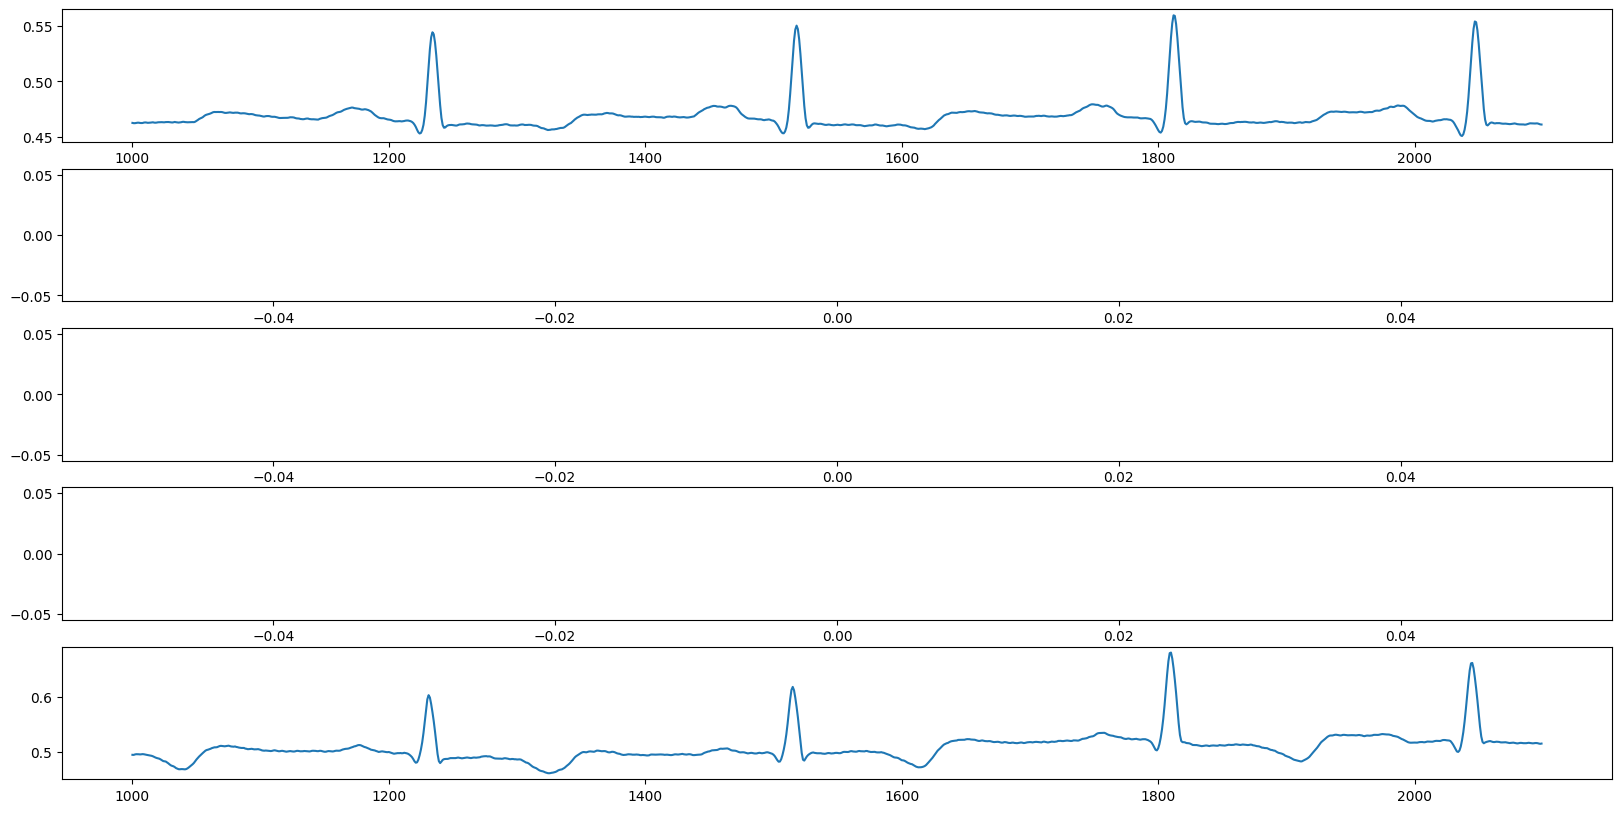

In [37]:
# Plot ecg examples with each feature in its subplot
plt.figure(figsize=(20, 10))
plt.subplot(511)
plt.plot(df['Sample #'][1000:2100], df['MLII'][1000:2100])
plt.subplot(512)
plt.plot(df['Sample #'][1000:2100], df['V1'][1000:2100])
plt.subplot(513)
plt.plot(df['Sample #'][1000:2100], df['V2'][1000:2100])
plt.subplot(514)
plt.plot(df['Sample #'][1000:2100], df['V4'][1000:2100])
plt.subplot(515)
plt.plot(df['Sample #'][1000:2100], df['V5'][1000:2100])
